# Import

In [76]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.util import ngrams
from collections import defaultdict
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

sns.set()
%matplotlib inline
stop = set(stopwords.words('english'))

# Settings

In [115]:
args = {
    'data_dir': '/data/ai_challenge/tweet_sentiment_extraction/',
    'train_file': 'train.csv',
    'test_file': 'test.csv',
    'original_file': 'tweet_dataset.csv',
    'save_model_dir': 'trained_model',
    
    'model_name': 'bert-base-uncased',
    'do_eval': False,
    'gradient_accumulation_steps': 1,
    'max_seq_length': 128,
    'batch_size': 8,
    'n_epoch': 3,
    'weight_decay': 1e-7,
    'adam_epsilon': 1e-8,
    'warmup_steps': 0,
    'n_splits': 5,
    'learning_rate': 1e-5,
    'seed': 1234,
}

# Load data

In [110]:
train_df = pd.read_csv(os.path.join(args['data_dir'], args['train_file']))
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [79]:
test_df = pd.read_csv(os.path.join(args['data_dir'], args['test_file']))
test_df.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -- skyscrapers galore). Good tweeps in China: (SH) (BJ).,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to quit her company, such a shame!",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [80]:
print(train_df.shape)
print(test_df.shape)

(27481, 4)
(3534, 3)


In [111]:
train_df = train_df.dropna(how='any',axis=0)
test_df = test_df.dropna(how='any',axis=0)

In [150]:
def check_selected_text(s):
    return s.selected_text in s.text

train_df['is_include'] = train_df.apply(check_selected_text, axis=1)

In [152]:
train_df['is_include'].value_counts()

True    27480
Name: is_include, dtype: int64

In [118]:
original_df = pd.read_csv(os.path.join(args['data_dir'], args['original_file']))
original_df = original_df.dropna(how='any', axis=0)

In [120]:
merge_df = pd.merge(train_df, original_df[['aux_id', 'sentiment']], left_on='textID', right_on='aux_id')
def merge_sentiment(s):
    return s['sentiment_x'] + " " + s['sentiment_y']
merge_df['sentiment'] = merge_df.apply(merge_sentiment, axis=1)

In [121]:
merge_df.head()

,textID,text,selected_text,sentiment_x,aux_id,sentiment_y,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,cb774db0d1,neutral,neutral neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,549e992a42,sadness,negative sadness
2,088c60f138,my boss is bullying me...,bullying me,negative,088c60f138,worry,negative worry
3,9642c003ef,what interview! leave me alone,leave me alone,negative,9642c003ef,worry,negative worry
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative,358bd9e861,hate,negative hate


# Augument data

In [100]:
def data_aug(s):
    text, selected_text = s.text, s.selected_text
    text_split = text.split(selected_text)
    text_begin, text_end = text_split[0], text_split[1]
    text_begin_cut = " ".join(text_begin.split()[1:])
    text_end_cut = " ".join(text_end.split()[:-1])
    
    return " ".join([text_begin_cut, selected_text, text_end_cut])

train_df_copy = train_df.copy()
train_df_copy['text'] = train_df.apply(data_aug, axis=1)
train_df_copy = train_df_copy[train_df_copy.sentiment != 'neutral']

In [94]:
train_df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [101]:
train_df_copy.head()

,textID,text,selected_text,sentiment
1,549e992a42,Sooo SAD I will miss you here in San,Sooo SAD,negative
2,088c60f138,boss is bullying me,bullying me,negative
3,9642c003ef,interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already","Sons of ****,",negative
6,6e0c6d75b1,feedings for the baby are fun when he is all smiles and,fun,positive


In [103]:
train_df_merge = pd.concat([train_df, train_df_copy])

In [105]:
train_df_merge.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative


In [106]:
train_df_merge = train_df_merge.sample(frac=1).reset_index(drop=True)

In [109]:
train_df_merge.head()

,textID,text,selected_text,sentiment
0,a8aa416961,fellow twitterers. if anyone one has a leather jacket for the size of a fat person (aka me) please let me borrow it.,fellow twitterers. if anyone one has a leather jacket for the size of a fat person (aka me) please let me borrow it.,neutral
1,4ad4131735,"Night, Happy Mother`s Day",Happy,positive
2,2708353196,at least you get to watch Lost on the way,at least you get to watch Lost on the way,neutral
3,2f3ac07330,Swimming is a no go for me,no go,negative
4,e5fc2bf284,I got Ben Button today... completes my Best Picture noms....got all 5 now. It was a GREAT year!!,It was a GREAT year!!,positive


# Selected text count

In [112]:
def selected_text_count(s):
    text, selected_text = s.text, s.selected_text
    text_split = text.split(selected_text)
    
    return len(text_split)

train_df.text_split = train_df.apply(selected_text_count, axis=1)

/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  import sys


In [113]:
train_df.text_split.value_counts()

2    27368
3    108  
4    3    
5    1    
dtype: int64

In [114]:
train_df[train_df.text_split > 2]

,textID,text,selected_text,sentiment
574,c3bdaf65c9,sorry guys i didn`t sign in for a while sorry every1,sorry,negative
723,5ea02d49eb,"Finally a chance to show genuine love, not dependent selfish love, I hope I can do it. My heart goes out to you and I`m sorry 4 ur pain.","love,",positive
729,d8ffeb6591,"Why does #googledocs do folders, instead of labels like #gmail? I kind of like labels",like,positive
1873,36c47981f9,would that just eat away at your masculinity? What masculinity did you have? :p haha u`d probs beat me tho haha xo,haha,positive
2167,fd53aa272c,scratchy scratchy throat. warm fluids needed,scratchy,negative
...,...,...,...,...
25591,de79cc363c,I had bad net issues on Weds so couldn`t broadcast Am on tonight tho... tune in for new anthems and bad mixing!,d bad,negative
25798,ca1cba337d,good morning! i hope you all have a good day today!! although its a monday... be positive! ;),good,positive
26127,1f1c138217,is feeling rather lonely and broke...oh wait...I am lonely and broke.,lonely,negative
26182,030151985f,so happy its friday...not so happy about this rain,happy,positive


# Statistic

## Label distribution

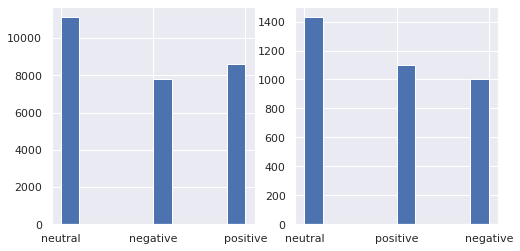

In [18]:
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
train_df['sentiment'].hist()
plt.subplot(1, 2, 2)
test_df['sentiment'].hist()

## Calculate word counts

In [53]:
train_df['word_count'] = train_df['text'].apply(lambda x: len(x.split()))
test_df['word_count'] = test_df['text'].apply(lambda x: len(x.split()))
train_df['word_count_selected'] = train_df['selected_text'].apply(lambda x: len(x.split()))

/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


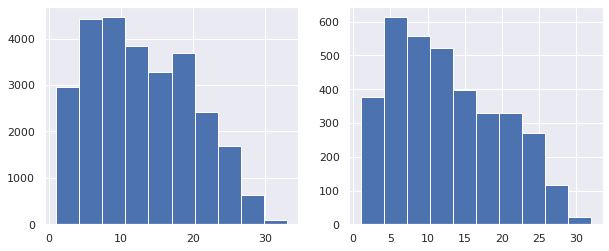

In [61]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
train_df['word_count'].hist()
plt.subplot(1, 2, 2)
test_df['word_count'].hist()

Text(0.5, 0.98, 'Word count for each sentiment on train and test datasets')

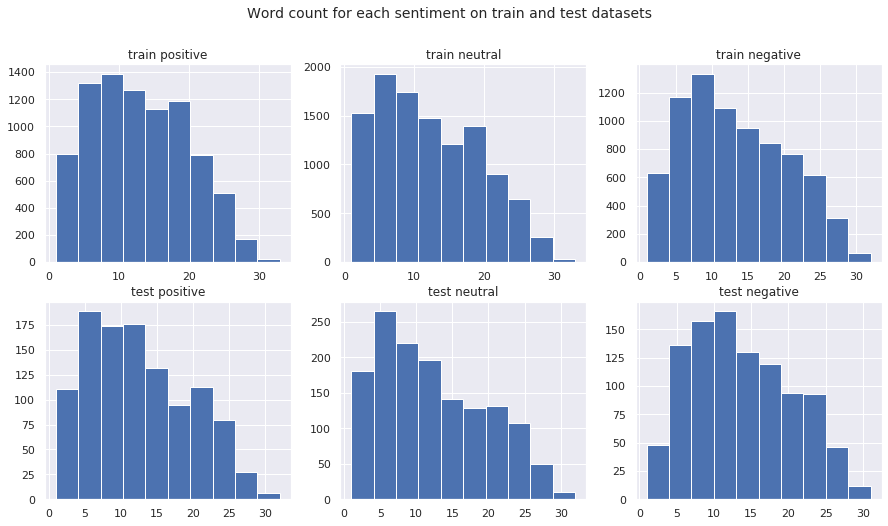

In [80]:
plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
train_df['word_count'][train_df['sentiment'] == 'positive'].hist()
plt.title('train positive')

plt.subplot(2, 3, 2)
train_df['word_count'][train_df['sentiment'] == 'neutral'].hist()
plt.title('train neutral')

plt.subplot(2, 3, 3)
train_df['word_count'][train_df['sentiment'] == 'negative'].hist()
plt.title('train negative')

plt.subplot(2, 3, 4)
test_df['word_count'][test_df['sentiment'] == 'positive'].hist()
plt.title('test positive')

plt.subplot(2, 3, 5)
test_df['word_count'][test_df['sentiment'] == 'neutral'].hist()
plt.title('test neutral')

plt.subplot(2, 3, 6)
test_df['word_count'][test_df['sentiment'] == 'negative'].hist()
plt.title('test negative')

plt.suptitle("Word count for each sentiment on train and test datasets", fontsize=14)

Text(0.5, 0.98, 'Selected word count for each sentiment on train datasets')

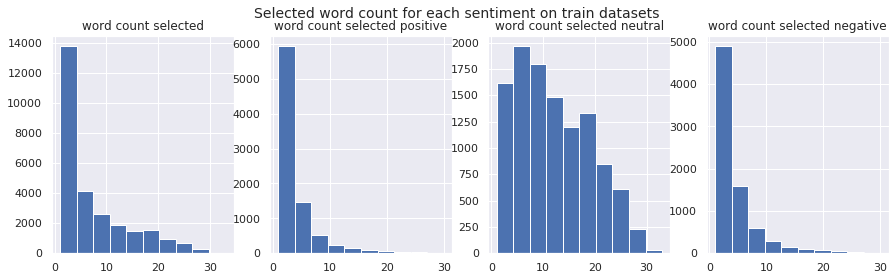

In [81]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
train_df['word_count_selected'].hist()
plt.title('word count selected')

plt.subplot(1, 4, 2)
train_df['word_count_selected'][train_df['sentiment'] == 'positive'].hist()
plt.title('word count selected positive')

plt.subplot(1, 4, 3)
train_df['word_count_selected'][train_df['sentiment'] == 'neutral'].hist()
plt.title('word count selected neutral')

plt.subplot(1, 4, 4)
train_df['word_count_selected'][train_df['sentiment'] == 'negative'].hist()
plt.title('word count selected negative')

plt.suptitle("Selected word count for each sentiment on train datasets", fontsize=14)

With neutral sentiment: Number of selected word is very high

In [63]:
def selected_rate(s):
    return s.word_count_selected/s.word_count
train_df['selected_rate'] = train_df.apply(selected_rate, axis=1)

/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Text(0.5, 0.98, 'Selected rate for each sentiment on train datasets')

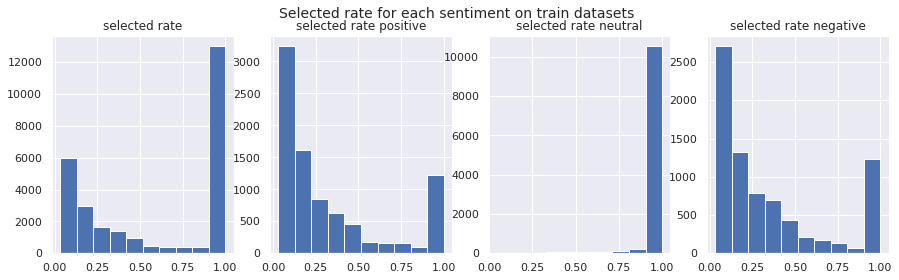

In [84]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 4, 1)
train_df['selected_rate'].hist()
plt.title('selected rate')

plt.subplot(1, 4, 2)
train_df['selected_rate'][train_df['sentiment'] == 'positive'].hist()
plt.title('selected rate positive')

plt.subplot(1, 4, 3)
train_df['selected_rate'][train_df['sentiment'] == 'neutral'].hist()
plt.title('selected rate neutral')

plt.subplot(1, 4, 4)
train_df['selected_rate'][train_df['sentiment'] == 'negative'].hist()
plt.title('selected rate negative')

plt.suptitle("Selected rate for each sentiment on train datasets", fontsize=14)

With neutral sentiment: most of word in sentence are chosen

## Word cloud

Text(0.5, 1.0, 'negative text')

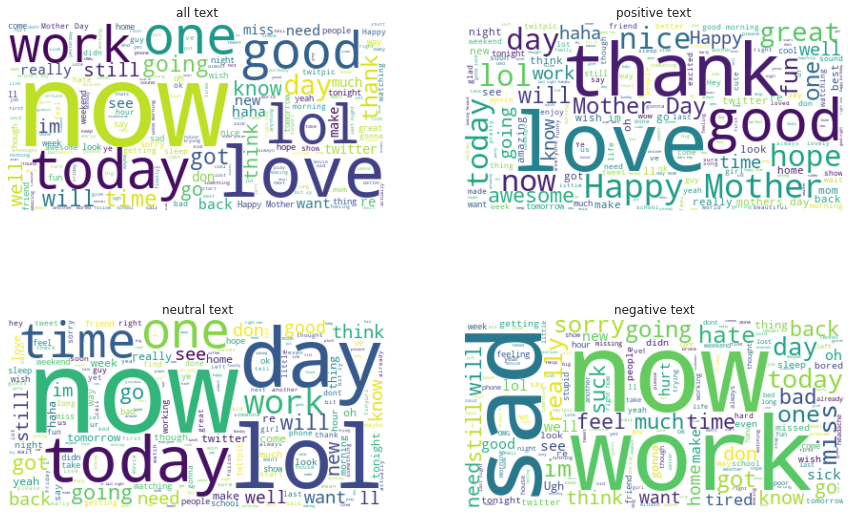

In [105]:
wordcloud = WordCloud(background_color="white")
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
text = " ".join(text for text in train_df['text'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('all text')
# plt.show()

plt.subplot(2, 2, 2)
text = " ".join(text for text in train_df['text'][train_df['sentiment'] == 'positive'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('positive text')
# plt.show()

plt.subplot(2, 2, 3)
text = " ".join(text for text in train_df['text'][train_df['sentiment'] == 'neutral'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('neutral text')
# plt.show()

plt.subplot(2, 2, 4)
text = " ".join(text for text in train_df['text'][train_df['sentiment'] == 'negative'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('negative text')
# plt.show()

Text(0.5, 1.0, 'negative text')

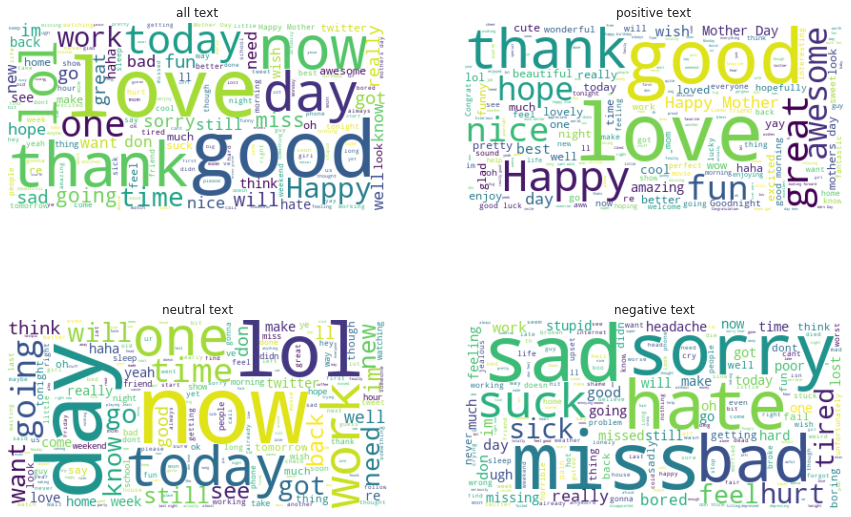

In [106]:
wordcloud = WordCloud(background_color="white")
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
text = " ".join(text for text in train_df['selected_text'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('all text')
# plt.show()

plt.subplot(2, 2, 2)
text = " ".join(text for text in train_df['selected_text'][train_df['sentiment'] == 'positive'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('positive text')
# plt.show()

plt.subplot(2, 2, 3)
text = " ".join(text for text in train_df['selected_text'][train_df['sentiment'] == 'neutral'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('neutral text')
# plt.show()

plt.subplot(2, 2, 4)
text = " ".join(text for text in train_df['selected_text'][train_df['sentiment'] == 'negative'])
cloud = wordcloud.generate(text)
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('negative text')
# plt.show()

## Stopwords

In [113]:
stopword_dict = defaultdict(int)
for i, row in train_df.iterrows():
    for word in row['text'].split():
        if word in stop:
            stopword_dict[word] += 1

<BarContainer object of 10 artists>

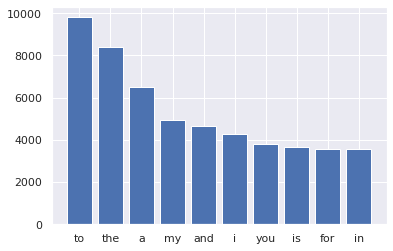

In [119]:
top = sorted(stopword_dict.items(), key=lambda x:x[1],reverse=True)[:10]
x, y = zip(*top)
plt.bar(x, y)

## N-gram

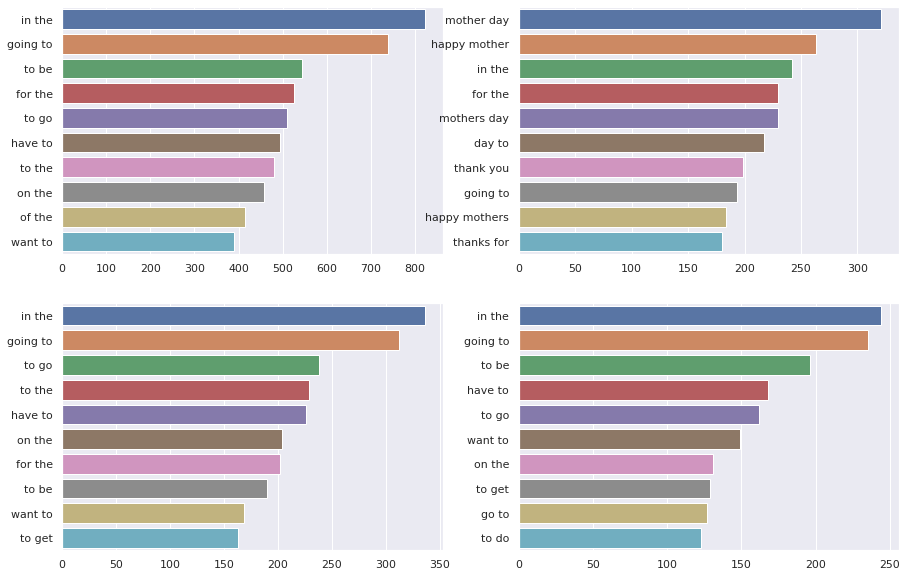

In [148]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['text'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 2)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['text'][train_df['sentiment'] == 'positive'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 3)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['text'][train_df['sentiment'] == 'neutral'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 4)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['text'][train_df['sentiment'] == 'negative'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

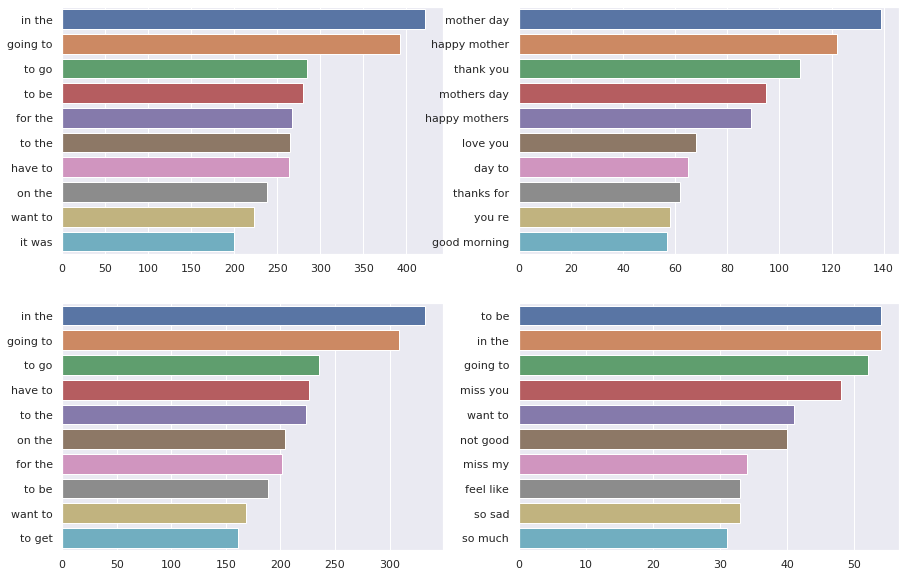

In [149]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['selected_text'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 2)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['selected_text'][train_df['sentiment'] == 'positive'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 3)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['selected_text'][train_df['sentiment'] == 'neutral'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

plt.subplot(2, 2, 4)
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2, 2)).fit(train_df['text'])
bag_of_words = vectorizer.transform(train_df['selected_text'][train_df['sentiment'] == 'negative'])
sum_words = bag_of_words.sum(axis=0) 
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse=True)
x,y = map(list,zip(*words_freq[:10]))
sns.barplot(x=y, y=x)

## Top positive/negative words

In [19]:
text = " ".join(text for text in train_df['selected_text'][train_df['sentiment'] == 'positive'])
filtered_words = [word for word in text.split() if word not in STOPWORDS]

counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)
    
print("Top positive words:", words)

['I', 'love', 'good', 'Happy', 'happy', 'great', 'day', 'fun', 'nice', 'thanks', 'hope', 'Good', 'Thanks', 'wish', 'awesome', 'best', 'really', 'I`m', 'better', 'thank']


In [20]:
text = " ".join(text for text in train_df['selected_text'][train_df['sentiment'] == 'negative'])
filtered_words = [word for word in text.split() if word not in STOPWORDS]

counted_words = Counter(filtered_words)

words = []
counts = []
for letter, count in counted_words.most_common(20):
    words.append(letter)
    counts.append(count)
    
print("Top negative words:", words)

['I', 'miss', 'I`m', '****', 'sad', 'hate', 'bad', 'sorry', 'don`t', 'feel', 'really', 'can`t', 'sick', 'good', 'im', 'tired', 'sucks', 'day', 'missed', 'hurts']


## Preprocess text

### URL

In [73]:
def find_url(text):
    return bool(re.search('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text))

train_df[train_df['selected_text'].apply(lambda x:find_url(x)) == True][train_df['sentiment'] != 'neutral']

/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,textID,text,selected_text,sentiment
3310,cc73efff2b,This song is a slap on you face!! ? http://blip.fm/~5jib6,This song is a slap on you face!! ? http://blip.fm/~5jib6,negative
4741,a8ed4e8266,wants see my friends ;-) http://plurk.com/p/wxnwa,wants see my friends ;-) http://plurk.com/p/wxnwa,positive
20376,1e4dd145b3,http://twitpic.com/674p1 - this is my Ohio is for lovers tattoo got the design off the shirt.. haha but I lost the shirt,http://twitpic.com/674p1 - this is my Ohio is for lovers tattoo got the design off the shirt.. haha but I lost the shirt,negative
22853,b31ee23c1c,Daddy just left.................without me http://yfrog.com/13pdrmj,Daddy just left.................without me http://yfrog.com/13pdrmj,negative
24374,38a69ed9ec,add me up: http://profiles.friendster.com/americanidolislove friendster.,add me up: http://profiles.friendster.com/americanidolislove friendster.,positive
26430,8223259736,Located & ordered a new cooker today. Feel I`ve got a real bargain from http://www.laskys.com ï¿½80 cheaper than the place I almost used.,Feel I`ve got a real bargain from http://www.laskys.com ï¿½80 cheaper than the place I almost used.,positive


### EMAIL

In [16]:
def find_email(text):
    line = re.findall(r'[\w\.-]+@[\w\.-]+',str(text))
    return ",".join(line)

train_df['text'].apply(lambda x:find_email(x)).value_counts()

    27480
Name: text, dtype: int64

### HTML

In [42]:
def find_html(text):
    return bool(re.search(r'<.*?>', text))

train_df[train_df['text'].apply(lambda x:find_html(x)) == True]

,textID,text,selected_text,sentiment
1783,a7c665c91e,on jacksonville beach walking in the cold **** water but have to work in the morning ily <(`-`)>,walking in the cold **** water,negative
9224,2cd25bd667,Allergies suck ducks nuts. <=====8=====>,Allergies suck,negative
12250,e17b606c9c,Whoishonorsociety <never wear your pajama pants to school >,Whoishonorsociety <never wear your pajama pants to school >,neutral
15294,1fbb8663c5,Good nite everybody! <:Baby Boy:>,Good,positive
17357,4ecaa31afa,) no more Chemistry!!! I`m gonna choose English. I find it (Chem.) kinda boring in the end! gonna help people < who choose Chem>,boring,negative
18683,f535ecec54,Welll my folkiesss(; im offf to dream land;work in the mornin;ugh;ewwy. Talkkk to me;but tomorrow <3 lurvee ya`ll[;>,Welll my folkiesss(; im offf to dream land;work in the mornin;ugh;ewwy. Talkkk to me;but tomorrow <3 lurvee ya`ll[;>,neutral
19888,de55035256,"I like fridays generally, but class is extended today and I`m starving :X haha </whine> O:-P","I like fridays generally, but class is extended today and I`m starving :X haha </whine>",neutral
21153,2c8c4b7f76,I never get them and the hubby is due in next week.. <cries> hope its gone by then,I never get them and the hubby is due in next week.. <cries> hope its gone by then,neutral
23645,388c6acb71,fireworks @ KBOOM concert... second best I`ve ever seen...preceded only by last year`s show 2008 <sigh>,second best,positive
25221,f3695fc09e,"Oh, ouch. That hurt. **** washing machine is out to get me! <.< >.>",hurt.,negative


### Emoji

In [44]:
def find_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return bool(emoji_pattern.search(text))

train_df[train_df['text'].apply(lambda x:find_emoji(x)) == True]

,textID,text,selected_text,sentiment


### Mention

In [47]:
def find_mention(text):
    return bool(re.search(r'(?<=@)\w+',text))

train_df[train_df['selected_text'].apply(lambda x:find_mention(x)) == True][train_df['sentiment'] != 'neutral']

/data/kits/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


,textID,text,selected_text,sentiment


### Punctuations

In [66]:
def find_punct(text):
    return bool(re.search(r'[!"\$%&\'()*+,\-.\/:;=#@?\[\\\]^_`{|}~]+', text))

train_df[train_df['selected_text'].apply(lambda x:find_punct(x)) == True]

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
4,358bd9e861,"Sons of ****, why couldn`t they put them on the releases we already bought","Sons of ****,",negative
5,28b57f3990,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,http://www.dothebouncy.com/smf - some shameless plugging for the best Rangers forum on earth,neutral
9,fc2cbefa9d,Journey!? Wow... u just became cooler. hehe... (is that possible!?),Wow... u just became cooler.,positive
10,2339a9b08b,"as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff","as much as i love to be hopeful, i reckon the chances are minimal =P i`m never gonna get my cake and stuff",neutral
...,...,...,...,...
27473,a208770a32,in spoke to you yesterday and u didnt respond girl wassup though!,in spoke to you yesterday and u didnt respond girl wassup though!,neutral
27477,4f4c4fc327,"I`ve wondered about rake to. The client has made it clear .NET only, don`t force devs to learn a new lang #agile #ccnet",", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - you probably need it after such hectic weekend Take care hun xxxx,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


### Label Errors

In [71]:
def is_include(s):
    if " " + s.selected_text + " " in " " + s.text + " ":
        return True
    else:
        return False
    
train_df[train_df.apply(is_include, axis=1) == False].head(50)

,textID,text,selected_text,sentiment
2,088c60f138,my boss is bullying me...,bullying me,negative
18,af3fed7fc3,is back home now gonna miss every one,onna,negative
27,bdc32ea43c,On the way to Malaysia...no internet access to Twit,.no internet,negative
32,1c31703aef,If it is any consolation I got my BMI tested hahaha it says I am obesed well so much for being unhappy for about 10 minutes.,well so much for being unhappy for about 10 minute,negative
39,2863f435bd,"A little happy for the wine jeje ok it`sm my free time so who cares, jaja i love this day",A little happy fo,positive
48,3d9d4b0b55,"i donbt like to peel prawns, i also dont like going shopping, running out of money and crawling round the car looking for more",dont like go,negative
49,3fcea4debc,which case? I got a new one last week and I`m not thrilled at all with mine.,d I`m not thrilled at all with mine.,negative
60,52483f7da8,"i lost all my friends, i`m alone and sleepy..i wanna go home","i lost all my friends, i`m alone and sleepy..",negative
64,98f25bc596,mannnn..... _ got an iphone!!! im jealous.... http://bit.ly/NgnaR,jealous..,negative
66,95e12b1cb1,He`s awesome... Have you worked with him before? He`s a good friend.,s awesome,positive
